In [2]:
import joblib
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random
import multiprocessing

from skbio.stats.composition import clr
from sklearn import model_selection, ensemble, metrics

import shared_functions

In [3]:
bf = joblib.load('joblib/catsNdogs_mw_bf.joblib')
data = joblib.load('joblib/catsNdogs_data.joblib')
di = data.info
cd = di[di.Host_type=='catNdog']
humans = di[(di.Host_type=='human')]

In [4]:
def pjc_curve(fixed_df,project_df,rf,tf,cpu_n_desired=7,max_comb_n=100,sample_n=5,random_st=0,col_name='project_name'):
    def _pjc(train_pj,test_pj,j):
        sample = shared_functions.sample_equal_categories_with_replacements(
            project_df,len(fixed_df),col_name,train_pj,j)
        ds = pd.concat([fixed_df,sample])
        taxa_df,chao_df,y = data.get_data_from_ind(ds.index,False)
        X = tf.transform_df(taxa_df,chao_df)
        rf.fit(X,y)
        res = []
        for t in test_pj:
            test_df = project_df[project_df[col_name]==t]
            test_taxa_df,test_chao_df,y_test = data.get_data_from_ind(test_df.index,False)
            X_test = tf.transform_df(test_taxa_df,test_chao_df)
            y_predict = rf.predict(X_test)
            acc = metrics.accuracy_score(y_test,y_predict)
            res.append({'train_projects_n':len(train_pj),'test_project':t,'sample_rs':j,
                   'accuracy':acc})
        return(res)
    pjcs = pd.unique(project_df[col_name])
    print('PJC parameters, max_comb_n:',max_comb_n,'sample_n:',sample_n,'random_st:',random_st)
    print('Projects used:',pjcs)
    random.seed(0)
    work_list = []
    for i in range(1,len(pjcs)):
        comb_list = list(itertools.combinations(pjcs, i))
        random.shuffle(comb_list)
        max_take = min(max_comb_n,len(comb_list))
        #print(max_take)
        comb_list = comb_list[:max_take]
        for comb in comb_list:
            anticomb = [x for x in pjcs if x not in comb]
            for j in range(sample_n):
                work_list.append((comb,anticomb,j))
    print('Work list size:',len(work_list))
    cpu_n = multiprocessing.cpu_count()
    n_jobs = min(cpu_n_desired,cpu_n-1)
    print('Using',n_jobs,'from',cpu_n,'cpus')
    results_list = Parallel(n_jobs=n_jobs)(delayed(_pjc)(p1,p2,p3) for p1,p2,p3 in work_list)
    flattened_list = [y for x in results_list for y in x]
    res_df = pd.DataFrame(flattened_list)
    return(res_df)

In [5]:
def draw_pjc(df,name):
    plt.figure(figsize=(20,8))
    sns.lineplot(x="train_projects_n", y="accuracy",hue="test_project",
                 ci='sd', data=df)
    plt.title(name)
    plt.show()

## Project curves for Genus models

Genus_ALL
PJC parameters, max_comb_n: 10 sample_n: 5 random_st: 0
Projects used: ['qiita_10928' '28191884' '28429209' '26179554' '29795809' '28195358'
 '25417156' '28179361' '31027508' '29404425']
Work list size: 450
Using 7 from 8 cpus


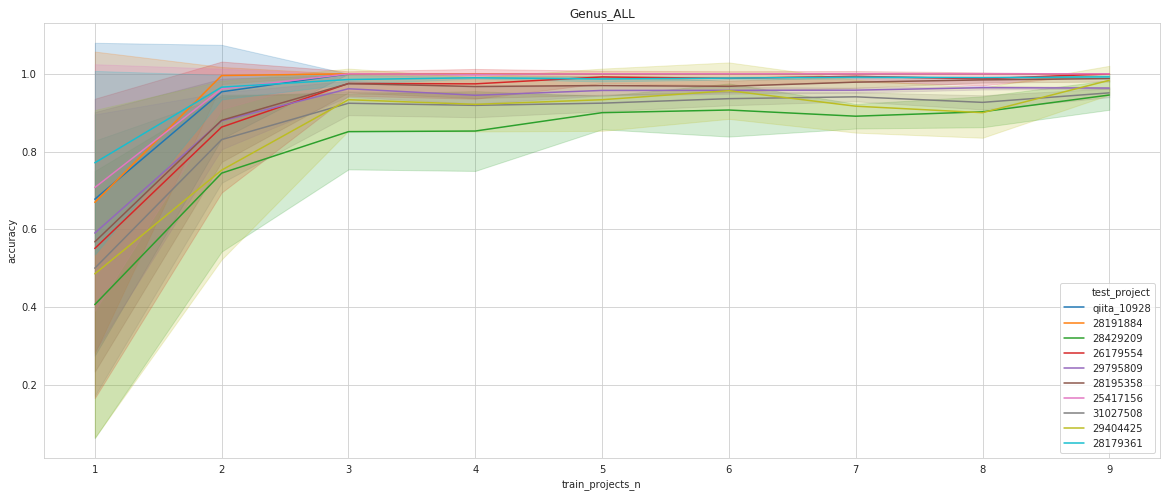

CPU times: user 5.12 s, sys: 296 ms, total: 5.42 s
Wall time: 33 s


In [7]:
%%time
#comb_n = 10
comb_n = 200
sample_n = 5
total_pjc_res = pd.DataFrame()
levels = [5]
features = ['all','best_holm','best_fdr']
clr_b = [False,True]
for level,features,clr_b in itertools.product(levels, features, clr_b):
    view_name = shared_functions.view_name(level,features,clr_b)
    print(view_name)
    filename = shared_functions.make_name(level,features,clr_b,False)
    rf = joblib.load('joblib/'+filename)   
    f,chao = bf[(level,features)]
    tf = shared_functions.transformer(bf=f,chao=chao,level=level,clr_b=clr_b)
    r = pjc_curve(fixed_df=cd,project_df=humans,rf=rf,tf=tf,max_comb_n=comb_n,sample_n=sample_n)
    draw_pjc(r,view_name)
    r['name'] = view_name
    r['level'] = shared_functions.get_tax_name_by_level(level)
    r['features'] = features
    r['CLR'] = clr_b
    total_pjc_res = pd.concat([total_pjc_res,r])

## Project curve averaged by test projects

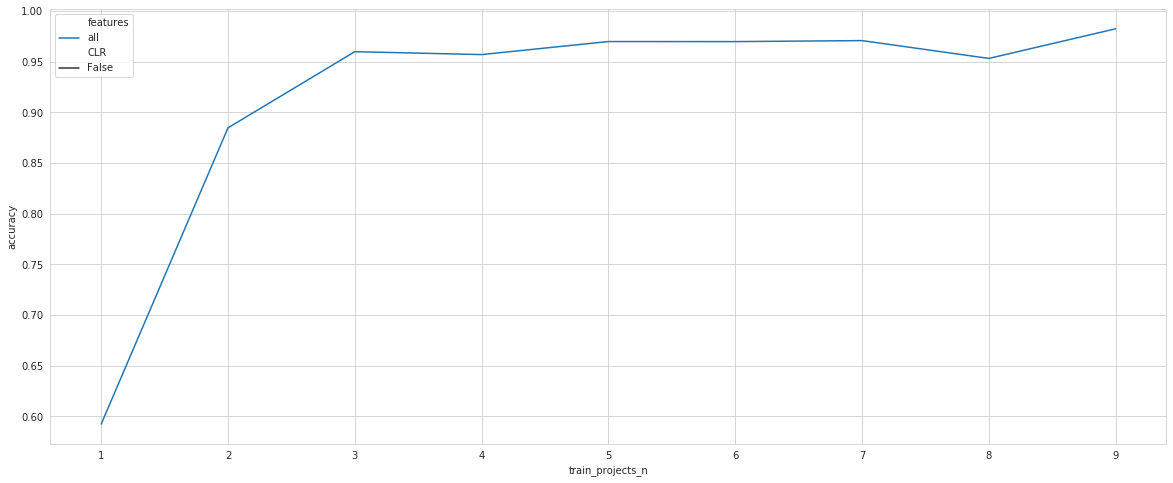

In [8]:
plt.figure(figsize=(20,8))
g = sns.lineplot(x="train_projects_n", y="accuracy",hue='features',style='CLR',
             ci=None, data=total_pjc_res)
#plt.title(name)

In [9]:
x = joblib.dump(total_pjc_res,'joblib/catsNdogs_pjc.joblib')